In [6]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import scipy.stats as stats
from scipy.optimize import curve_fit
import scipy.io as sio

from matplotlib import colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import  matplotlib.markers as mark


from matplotlib.legend_handler import HandlerPatch
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib import cm

import os
from os.path import expanduser

import pickle



import torch
# from tqdm import tqdm

from rnn_hierarchical_withTau import RNN_stack

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
ft = 14
# graphical properties
plt.rcParams["axes.edgecolor"] = "k"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["axes.linewidth"] = "0.8"
plt.rcParams.update({'font.size': ft})
plt.rcParams['savefig.dpi'] = 300

plt.rcParams['pdf.fonttype'] = 42 # prepare as vector graphic
plt.rcParams['ps.fonttype'] = 42

plt.rcParams["font.family"] = "Helvetica"


save_fig_path = expanduser("~") + '/research/data/projects/rnn_timescales/neurips_23/'

col_sig_par = '#D48A6A' #, if too light #AA5B39
col_sig_dms = '#803515'

col_multi_par =  '#74AE97' #, if too light #277455
col_multi_dms =  '#0E573A'

# Load data

In [8]:
num_neurons = 500
NET_SIZE = [num_neurons]

INPUT_SIZE = 1
NUM_CLASSES = 2
BIAS = True
NUM_READOUT_HEADS = 100
TRAIN_TAU = True


## load taus

In [9]:
def load_network_single_parity(path, network_name, N):    
    rnn = torch.load(path +  network_name +'/'+ 'rnn_Nbit-N' + str(N) \
                           +'-parity_net-size-500_bias-True_input-size-1',  map_location=torch.device('cpu'))
    return rnn

def load_network_parity_multi(path, sub_dir, network_name, N):
    sub_dir = sub_dir + network_name
    if (N  <= 9):
        curr = 'rnn_N02' + '_N0' + str(N) +'-500'
    else:
        curr = 'rnn_N02' + '_N' + str(N) +'-500'
       
    filename = f'{path}/{sub_dir}/{curr}/{curr}'
    
    rnn = init_model()
    rnn.load_state_dict(torch.load(filename, map_location=torch.device('cpu'))['state_dict'], strict=False)
    return rnn

def load_network_dms_single(path, sub_dir, network_name, N):    
    sub_dir = sub_dir + network_name
    N_min = N
    curr = 'rnn_' + 'N' + str(N_min).zfill(3) + '-N' + str(N).zfill(3) +'-500'
       
    filename = f'{path}/{sub_dir}/{curr}/{curr}'
    
    rnn = init_model()
    rnn.load_state_dict(torch.load(filename, map_location=torch.device('cpu'))['state_dict'], strict=False)
    return rnn


def load_network_dms_multi(path, sub_dir, network_name, N):    
    sub_dir = sub_dir + network_name
    N_min = 2
    curr = 'rnn_' + 'N' + str(N_min).zfill(3) + '-N' + str(N).zfill(3) +'-500'
       
    filename = f'{path}/{sub_dir}/{curr}/{curr}'
    
    rnn = init_model()
    rnn.load_state_dict(torch.load(filename, map_location=torch.device('cpu'))['state_dict'], strict=False)
    return rnn

def init_model():

    # init new model
    rnn = RNN_stack(input_size=INPUT_SIZE,
                    net_size=NET_SIZE,
                    num_classes=NUM_CLASSES,
                    bias=BIAS,
                    num_readout_heads=NUM_READOUT_HEADS,
                    tau=1.,
                    train_tau=TRAIN_TAU
                    ).to(device)    
    return rnn

In [10]:
def load_trained_taus(rnn):    
    taus = rnn.taus[0].detach().numpy() # trained taus 
    return taus


In [11]:
def compute_mean_std_tau(path, net_type, net_ids, N_range, sub_dir):
    tau_mean_mean = np.zeros(len(N_range))
    tau_mean_std = np.zeros(len(N_range))
    tau_std_mean = np.zeros(len(N_range))
    tau_std_std = np.zeros(len(N_range))
    for i, N in enumerate(N_range):
        taus_all_N = []
        taus_net_avg = np.zeros(len(net_ids))
        taus_net_std = np.zeros(len(net_ids))
        for j, net_id in enumerate(net_ids):
            network_name = 'network_'+str(net_id)
            
            # loading the network 
            if net_type == 0:
                rnn = load_network_single_parity(path, network_name, N)
            elif net_type == 1:
                rnn = load_network_parity_multi(path, sub_dir, network_name, N)
            elif net_type == 2:
                rnn = load_network_dms_single(path, sub_dir, network_name, N)
            elif net_type == 3:
                rnn = load_network_dms_multi(path, sub_dir, network_name, N)
            else:
                print('something is wrong')
            
            taus = rnn.taus[0].detach().numpy()
            taus_all_N = np.concatenate((taus_all_N, taus))

            taus_net_avg[j] = np.mean(taus)
            taus_net_std[j] = np.std(taus)
        

        tau_mean_mean[i] = np.mean(taus_net_avg)
        tau_std_mean[i] = np.std(taus_net_avg)
        tau_mean_std[i] = np.mean(taus_net_std)
        tau_std_std[i] = np.std(taus_net_std)
        
#         tau_std[i] = np.mean(taus_net_std)
#         tau_std[i] = np.std(taus_net_avg)
#         tau_mean[i] = np.mean(taus_all_N)
#         tau_std[i] = np.std(taus_all_N)
        
        
    return tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std

In [18]:
def load_taus_new(path, curriculum_type, task, affixes, network_number, N):
    
    affix_str = '_'
    if len(affixes) > 0:
        affix_str += '_'.join(affixes) + '_'
    
    model_name = os.path.join(
        f'{curriculum_type}_{task}{affix_str}network_{network_number}')
    
    with open(path + model_name +'_N'+str(N) + '_acs_taus.pkl', 'rb') as f:
            data = pickle.load(f)
    tau_eff = data['taus_net']
    selected_models = data['selected_models']
    trained_taus = data['taus_trained']
    single_acs = data['ac_all']
    ac_pop = data['ac_pop']
    
            
#     tau_eff = np.array(tau_eff)
    return tau_eff, selected_models, trained_taus, single_acs, ac_pop 

def compute_mean_std_tau_eff(net_ids, N_range, path, curriculum_type, task, affixes):
    tau_mean_mean = np.zeros(len(N_range))
    tau_std_mean = np.zeros(len(N_range)) 
    tau_mean_std = np.zeros(len(N_range))
    tau_std_std = np.zeros(len(N_range))
    for i, N in enumerate(N_range):
        train_taus_all = []
        eff_taus_all = []
        eff_taus_net_avg = np.zeros(len(net_ids))
        eff_taus_net_std = np.zeros(len(net_ids))
        for j, net_id in enumerate(net_ids):
            network_name = 'network_'+str(net_id)
            tau_eff, selected_models, trained_taus, single_acs, ac_pop =\
            load_taus_new(path, curriculum_type, task, affixes, net_id, N)
    #         tau_eff = tau_eff[(tau_eff>1)& (tau_eff<99)]
            tau_eff = tau_eff[(tau_eff>1)]

            eff_taus_net_avg[j] = np.mean(tau_eff)
            eff_taus_net_std[j] = np.std(tau_eff)

        tau_mean_mean[i] = np.mean(eff_taus_net_avg)
        tau_std_mean[i] = np.std(eff_taus_net_avg)
        tau_mean_std[i] = np.mean(eff_taus_net_std)
        tau_std_std[i] = np.std(eff_taus_net_std)
        
    return tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std


def compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes):
    tau_mean_mean = np.zeros(len(N_range))
    tau_std_mean = np.zeros(len(N_range)) 
    tau_mean_std = np.zeros(len(N_range))
    tau_std_std = np.zeros(len(N_range))
    for i, N in enumerate(N_range):
        train_taus_all = []
        train_taus_all = []
        train_taus_net_avg = np.zeros(len(net_ids))
        train_taus_net_std = np.zeros(len(net_ids))
        for j, net_id in enumerate(net_ids):
            network_name = 'network_'+str(net_id)
            tau_eff, selected_models, trained_taus, single_acs, ac_pop =\
            load_taus_new(path, curriculum_type, task, affixes, net_id, N)

            train_taus_net_avg[j] = np.mean(trained_taus)
            train_taus_net_std[j] = np.std(trained_taus)

        tau_mean_mean[i] = np.mean(train_taus_net_avg)
        tau_std_mean[i] = np.std(train_taus_net_avg)
        tau_mean_std[i] = np.mean(train_taus_net_std)
        tau_std_std[i] = np.std(train_taus_net_std)
        
    return tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std

<ErrorbarContainer object of 3 artists>

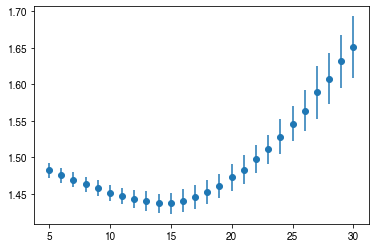

In [12]:
path = expanduser("~") + '/research/projects/rnn_timescales_local/Hel/n_bit_parity/models_tau_train/'

net_ids = np.arange(1,5)
N_range = np.arange(5,31,1)
sub_dir = ''
net_type = 0

tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  = compute_mean_std_tau(path, net_type, net_ids, N_range, sub_dir)
plt.errorbar(N_range, tau_mean_mean, yerr = tau_std_mean, fmt = 'o')

In [13]:
final_N_singlehead_trained = np.array([37, 33, 35, 35])
final_N_singlehead_tau1 = np.array([24, 25, 24, 26])
final_N_singlehead_tau2 = np.array([26, 25, 26, 26])
final_N_singlehead_tau3 = np.array([25, 24, 24, 24])
final_N_singlehead_tau4 = np.array([24,23, 23, 23])

final_N_singlehead_tau = [final_N_singlehead_tau1,
                          final_N_singlehead_tau2,
                          final_N_singlehead_tau3]



In [14]:
final_N_multihead_trained = np.array([100, 101, 100, 101])
final_N_multihead_tau1 = np.array([101, 101, 101, 101])
final_N_multihead_tau2 = np.array([87, 88, 87, 87])
final_N_multihead_tau3 = np.array([66, 70, 70, 72])
final_N_multihead_tau5 = np.array([50])

final_N_multihead_tau = [final_N_multihead_tau1,
                          final_N_multihead_tau2,
                          final_N_multihead_tau3]

# Plot

In [20]:
col_sig_par = '#D48A6A' #, if too light #AA5B39
col_sig_dms = '#803515'

col_multi_par =  '#74AE97' #, if too light #277455
col_multi_dms =  '#0E573A'

# loading data for panels
path_parity_new = expanduser("~") + '/research/data/projects/rnn_timescales/ac/ac_tau_loc_nonlin_correct/'
task = 'parity'
affixes = ['mod', 'leakyrelu']
path = path_parity_new

In [16]:
def plot_shade(x, mean, std, color):
    ax.fill_between(
        x,
        mean - std,
        mean + std,
        color=color,
        alpha=0.2,
    )

In [17]:
# loading panels

# # single DMS
# path = expanduser("~") + '/research/projects/rnn_timescales_local/Hel/n_bit_parity/models_bDMS_complete/'
# N_range = np.arange(2,94,1)
# sub_dir = 'train_curr_1_at_a_time_with_forgetting_1_bDMS_'
# net_type = 2
# tau_mean_mean_sing_dms, tau_mean_std_sing_dms,  tau_std_mean_sing_dms, tau_std_std_sing_dms  = \
# compute_mean_std_tau(path, net_type, net_ids, N_range, sub_dir)

# single N-parity
path = expanduser("~") + '/research/projects/rnn_timescales_local/Hel/n_bit_parity/models_tau_train/'
N_range = np.arange(2,33,1)
sub_dir = ''
net_type = 0
tau_mean_mean_sing_par, tau_mean_std_sing_par,  tau_std_mean_sing_par, tau_std_std_sing_par  = \
compute_mean_std_tau(path, net_type, net_ids, N_range, sub_dir)

# # multi DMS
# path = expanduser("~") + '/research/projects/rnn_timescales_local/Hel/n_bit_parity/models_bDSM/multi_head/'
# N_range = np.arange(2,100,1)
# sub_dir = 'train_curr_cumulative_1_heads_bDMS_'
# net_type = 3
# tau_mean_mean_multi_dms, tau_mean_std_multi_dms,  tau_std_mean_multi_dms, tau_std_std_multi_dms  = \
# compute_mean_std_tau(path, net_type, net_ids, N_range, sub_dir)

# multi N-parity
path = expanduser("~") + '/research/projects/rnn_timescales_local/Hel/n_bit_parity/models_multi_head/'
N_range = np.arange(2,100,1)
sub_dir = 'train_curr_cumulative_1_heads_'
net_type = 1
tau_mean_mean_multi_par, tau_mean_std_multi_par,  tau_std_mean_multi_par, tau_std_std_multi_par  = \
compute_mean_std_tau(path, net_type, net_ids, N_range, sub_dir)

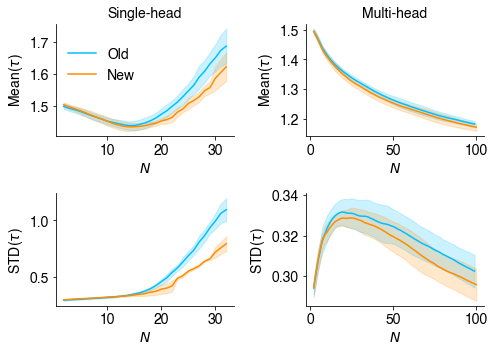

In [50]:
cm = 1/2.54  # centimeters in inches
fig = plt.figure(figsize=(18*cm, 13*cm))


alpha_dot = 0.6
w = 0.35 #width of mean line
ms = 8
lw = 2

x_text = -.4
y_text = 1.1

x_noise = 0.05
c_singlehead = '#D48A6A'
c_multihead = '#489174'
#c_trained = '#5A78E6'
c_new = 'darkorange'
c_old = 'deepskyblue'


ms = 3
lw = 1.5
elw = 1.5

y1 = .9
y2 = 2

ax = plt.subplot(221)
# ax.text(x_text,y_text,'b',color='k',fontsize=ft+1,weight='bold', transform=ax.transAxes)

net_ids = np.arange(1,5)

# single, old
N_range = np.arange(2,33,1)
plt.plot(N_range, tau_mean_mean_sing_par, lw = lw, color = c_old, label = 'Old')
plot_shade(N_range, tau_mean_mean_sing_par, tau_std_mean_sing_par, c_old)


# single, new
net_ids = [0,2,3]
N_range = np.arange(2,33,1)
curriculum_type = 'single'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_mean, color = c_new, lw = lw, label = 'New')
plot_shade(N_range, tau_mean_mean, tau_std_mean, c_new)

plt.ylabel(r'Mean($\tau$)')
plt.xlabel(r'$N$')
plt.title('Single-head', fontsize = ft)
# plt.ylim([y1, y2])

plt.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(0,.9))

ax = plt.subplot(222)
net_ids = np.arange(1,5)
# ax.axhline(y = 1, ls = '--', color = 'gray')


# multi, old
N_range = np.arange(2,100,1)
plt.plot(N_range, tau_mean_mean_multi_par, lw = lw, color = c_old, label = 'N-parity')
plot_shade(N_range, tau_mean_mean_multi_par, tau_std_mean_multi_par, c_old)


# Parity, multi
net_ids = np.arange(0,4)
N_range = np.arange(2,101,1)
curriculum_type = 'cumulative'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_mean, color = c_new, lw = lw, label = 'Multi-N')
plot_shade(N_range, tau_mean_mean, tau_std_mean, c_new)

plt.title('Multi-head', fontsize = ft)


fig.tight_layout()
# plt.legend(frameon = False, loc = 'upper right', bbox_to_anchor=(1,1.1))
plt.xlabel(r'$N$')
# plt.title('Multi-head', fontsize = ft)
plt.ylabel(r'Mean($\tau$)')
plt.xlabel(r'$N$')
# plt.ylim([y1, y2])

#-------------------------------------------------------------------------------------------------------

ax = plt.subplot(223)
net_ids = np.arange(1,5)

y1 = 0.2
y2 = 1.2

# single, old
N_range = np.arange(2,33,1)
plt.plot(N_range, tau_mean_std_sing_par, lw = lw, color = c_old, label = 'N-parity')
plot_shade(N_range, tau_mean_std_sing_par, tau_std_std_sing_par, c_old)

# single, new
net_ids = [0,2,3]
N_range = np.arange(2,33,1)
curriculum_type = 'single'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_std, color = c_new, lw = lw, label = 'New')
plot_shade(N_range, tau_mean_std, tau_std_std, c_new)

# plt.legend(frameon = False, loc = 'upper left', bbox_to_anchor=(0,1.1))
plt.ylabel(r'STD($\tau$)')
plt.xlabel(r'$N$')
# plt.title('Single-head', fontsize = ft)

ax = plt.subplot(224)
net_ids = np.arange(1,5)


# multi, old
N_range = np.arange(2,100,1)
plt.plot(N_range, tau_mean_std_multi_par, lw = lw, color = c_old, label = 'N-parity')
plot_shade(N_range, tau_mean_std_multi_par, tau_std_std_multi_par, c_old)

# Parity, multi
net_ids = np.arange(0,4)
N_range = np.arange(2,101,1)
curriculum_type = 'cumulative'
tau_mean_mean, tau_mean_std,  tau_std_mean, tau_std_std  =\
compute_mean_std_tau_train(net_ids, N_range, path, curriculum_type, task, affixes)
plt.plot(N_range, tau_mean_std, color = c_new, lw = lw, label = 'Multi-N')
plot_shade(N_range, tau_mean_std, tau_std_std, c_new)

# plt.legend(frameon = False, loc = 'upper right', bbox_to_anchor=(1,1.1))
plt.ylabel(r'STD($\tau$)')
plt.xlabel(r'$N$')
# plt.title('Multi-head', fontsize = ft)
# plt.ylim([y1, y2])
# plt.legend(frameon = False, loc = 'upper right', bbox_to_anchor=(1.1,1.5),\
#            handletextpad= 0.2, handlelength = 0.8, ncol = 4, columnspacing=0.7)


fig.tight_layout()

sns.despine()

In [15]:
# fig.savefig(save_fig_path +'fig_training_taus_v3.pdf')